# Lseg Demo

## Visualization tools

In [2]:
# Utility Functions
# Import Libraries
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from matplotlib.patches import Patch
import torchvision.transforms as transforms
from PIL import Image

def generate_color_map(num_classes):
    """
    Generate a color map for visualizing segmentation masks.
    Args:
        num_classes: Total number of classes.
    Returns:
        color_map: A dictionary mapping class indices to RGB tuples.
    """
    np.random.seed(0)  # Ensures consistent colors across runs
    color_map = {i: np.random.randint(0, 255, size=3) for i in range(num_classes)}
    color_map[num_classes - 1] = np.array([0, 0, 0])  # Black for background
    return color_map


def apply_color_map(label_tensor, color_map):
    """
    Map a label tensor to an RGB image using the provided color map.
    Args:
        label_tensor: A torch tensor of shape [H, W] containing class labels.
        color_map: A dictionary mapping class indices to RGB tuples.
    Returns:
        rgb_image: An RGB image of shape [H, W, 3].
    """
    label_array = label_tensor.numpy()
    h, w = label_array.shape
    rgb_image = np.zeros((h, w, 3), dtype=np.uint8)
    for class_idx, color in color_map.items():
        rgb_image[label_array == class_idx] = color
    return rgb_image


def denormalize_image(
    tensor: torch.Tensor, mean: list = [0.485, 0.456, 0.406], std: list = [0.229, 0.224, 0.225]
) -> torch.Tensor:
    """
    Denormalizes a tensor that was normalized using torchvision.transforms.Normalize.

    Args:
        tensor (torch.Tensor): The normalized image tensor with shape (N, C, H, W) or (C, H, W).
        mean (list): The mean values used for normalization, e.g., [0.485, 0.456, 0.406].
        std (list): The std values used for normalization, e.g., [0.229, 0.224, 0.225].

    Returns:
        torch.Tensor: The denormalized tensor.
    """
    if tensor.ndim != 4:
        raise ValueError("Input tensor must have shape (N, C, H, W).")

    # Convert mean and std to tensors and reshape for broadcasting
    mean = torch.tensor(mean).view(1, -1, 1, 1)
    std = torch.tensor(std).view(1, -1, 1, 1)

    # Denormalize: (tensor * std) + mean
    return tensor * std + mean


def visualize_predictions(predictions, color_map, labels, title="Segmentation"):
    """
    Visualize segmentation predictions with a legend for labels.
    Args:
        predictions: A torch tensor of shape [H, W].
        color_map: A dictionary mapping class indices to RGB tuples.
        labels: A list of class label names.
        title: Title of the plot.
    """
    # Apply color map to the predictions
    rgb_image = apply_color_map(predictions, color_map)

    # Create the figure
    plt.figure(figsize=(10, 6))
    plt.imshow(rgb_image)
    plt.title(title)
    plt.axis("off")

    # Filter legend to include only present labels
    unique_classes = torch.unique(predictions).tolist()
    legend_elements = [Patch(facecolor=np.array(color_map[idx]) / 255.0, label=labels[idx]) for idx in unique_classes]

    plt.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(1.2, 1), title="Labels", fontsize="small")
    plt.show()


def visualize_images(imgs: torch.Tensor):
    """
    Displays images from a batch of PyTorch tensors.

    Args:
        imgs (torch.Tensor): The input image imgs with shape (N, C, H, W).
        batch_size (int, optional): The number of images to display. Defaults to None, which displays all images.
    """
    if imgs.ndim != 4:
        raise ValueError("Input imgs must have shape (N, C, H, W).")
    batch_size = imgs.shape[0]
    # Display each image in the batch
    for i in range(batch_size):
        image = imgs[i]  # Extract the i-th image
        image = transforms.ToPILImage()(image)  # Convert to PIL Image
        # Display the image}
        image.show(title=f"Image {i+1}")

## Model

In [3]:
from LsegNet import LitLseg
from Lseg.utils.util import get_dataset, get_labels

# model initialization

# Define model
labels = get_labels()

config = {
    "max_epochs": 50,
    "num_classes": len(labels),
    "batch_size": 12,
    "base_lr": 0.04,
}

# load model 
load_checkpoint_path = r'checkpoints/checkpoint_epoch=0-val_loss=4.7199.ckpt'
model = LitLseg.load_from_checkpoint(
    load_checkpoint_path,
    max_epochs = config['max_epochs'],
    num_classes = config['num_classes'],
    batch_size = config['batch_size'],
    base_lr = config['base_lr'],
)
model.eval();

/home/rotakagui/miniconda3/envs/CLIP/lib/python3.8/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [4]:
from torch.utils.data import DataLoader

test_dataset  = get_dataset(dataset_name="coco", get_train=False, resize_size=(320, 320))
test_dataloaders  = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=8)
color_map = generate_color_map(len(labels))


	Mapping ade20k-150 -> universal
	Mapping bdd -> universal
	Mapping cityscapes-19 -> universal
	Mapping coco-panoptic-133 -> universal
	Mapping idd-39 -> universal
	Mapping mapillary-public65 -> universal
	Mapping sunrgbd-37 -> universal
	Mapping ade20k-150-relabeled -> universal
	Mapping bdd-relabeled -> universal
	Mapping cityscapes-19-relabeled -> universal
	Mapping cityscapes-34-relabeled -> universal
	Mapping coco-panoptic-133-relabeled -> universal
	Mapping idd-39-relabeled -> universal
	Mapping mapillary-public65-relabeled -> universal
	Mapping sunrgbd-37-relabeled -> universal

	Creating 1x1 conv for test datasets...
Totally 5000 samples in val set.
Checking image&label pair val list done!
image folder path: data/mseg_dataset/COCOPanoptic/
text path: mseg-api/mseg/dataset_lists/coco-panoptic-133-relabeled/list/val.txt


tensor([ 17,  24,  36,  42,  43,  57,  64,  67,  82,  87,  90, 103, 105, 106,
        125, 173, 174, 191, 192, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


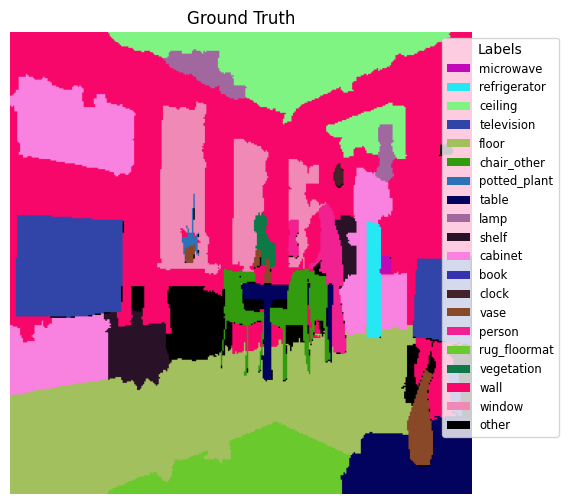

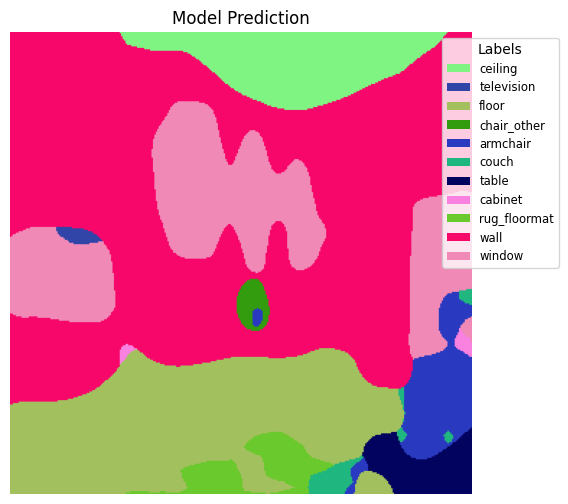

tensor([ 13, 102, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


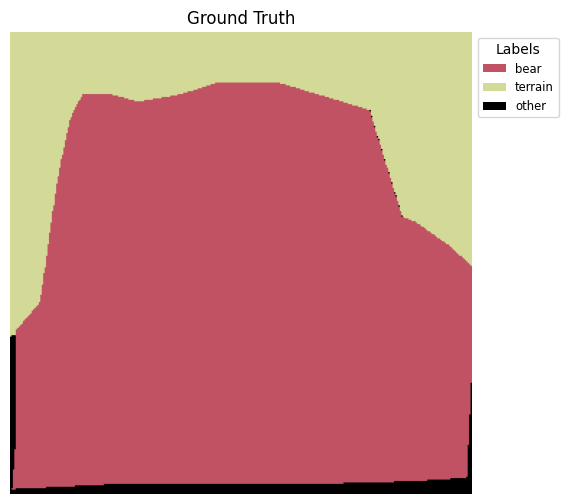

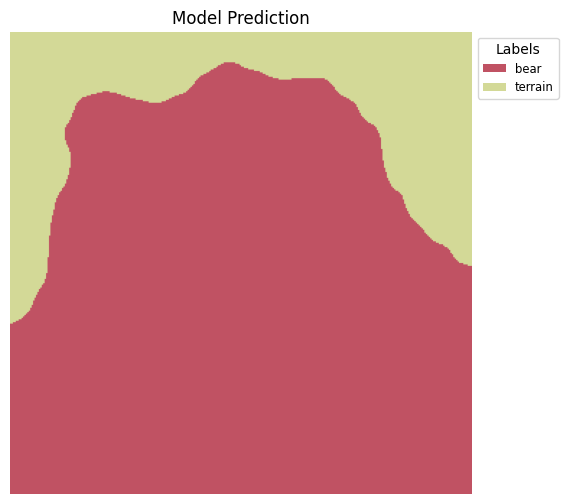

tensor([ 35,  58,  64,  66, 103, 168, 174, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


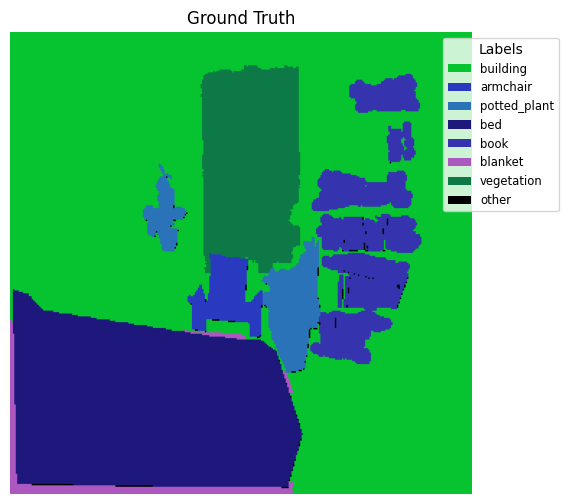

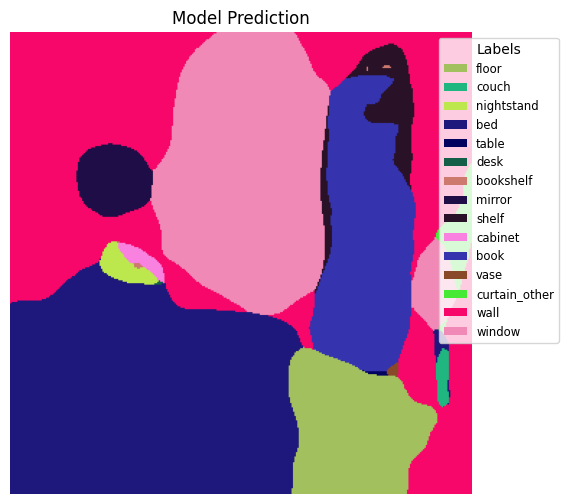

tensor([ 98, 102, 135, 142, 174, 176, 182, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


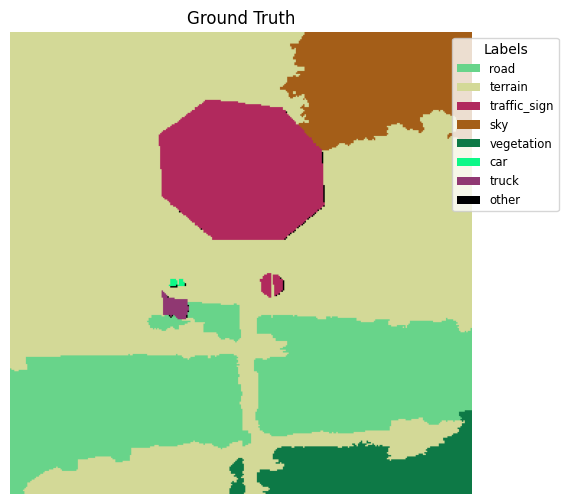

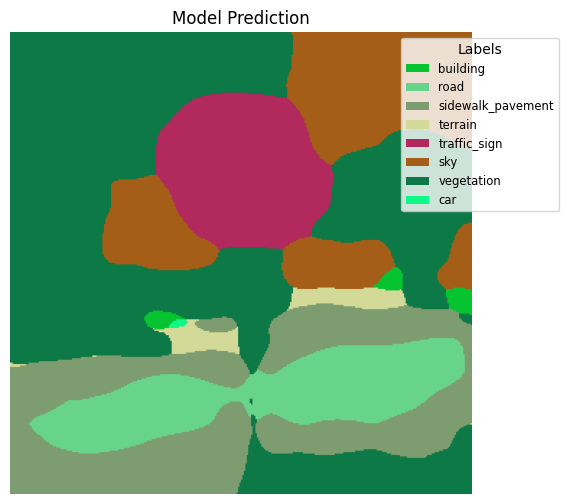

tensor([ 66, 109, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


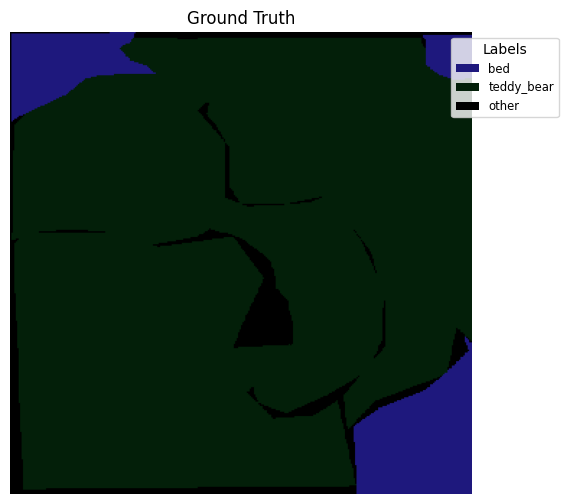

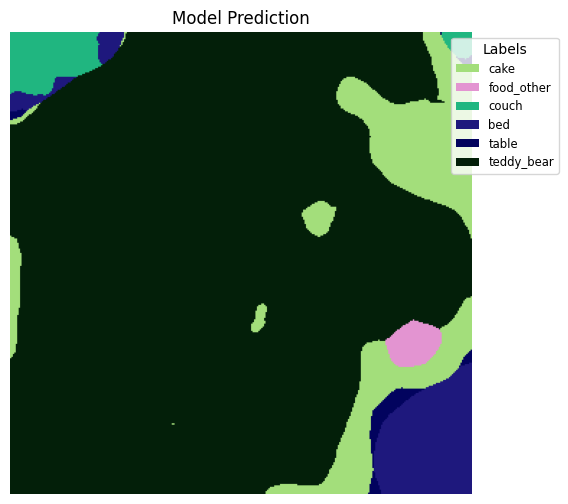

tensor([ 99, 125, 142, 150, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


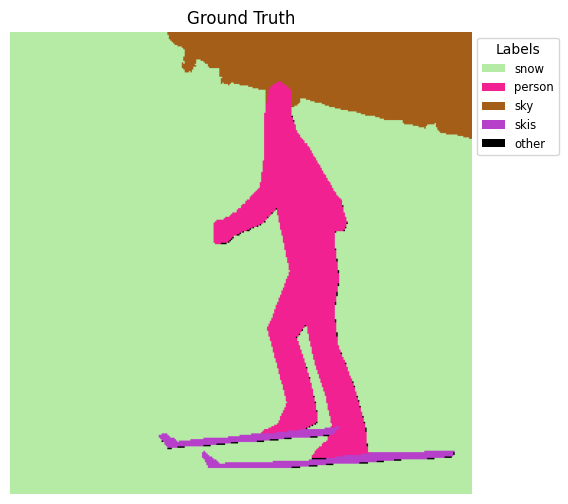

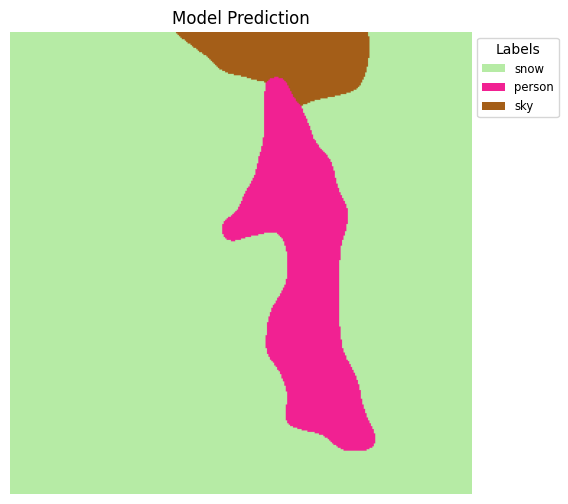

tensor([ 19,  24,  36,  43, 191, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


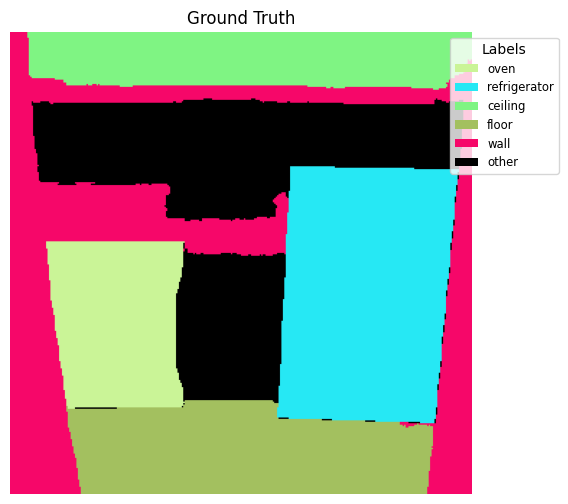

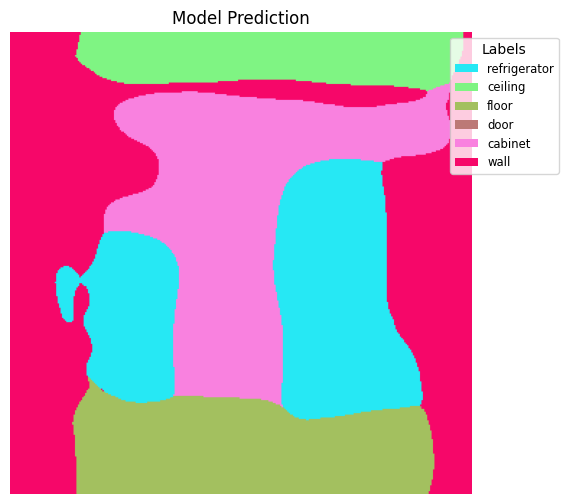

tensor([ 96, 102, 125, 152, 155, 174, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


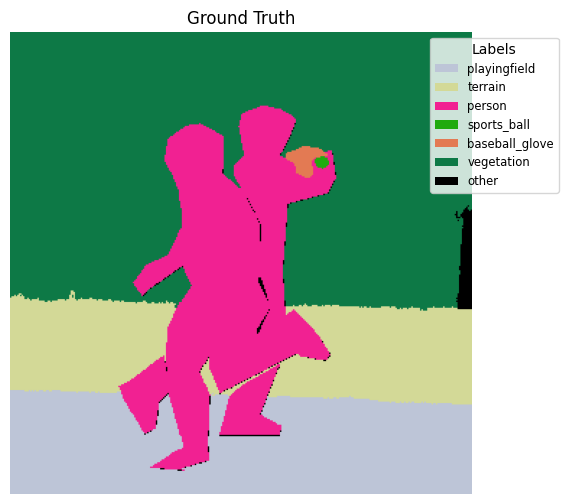

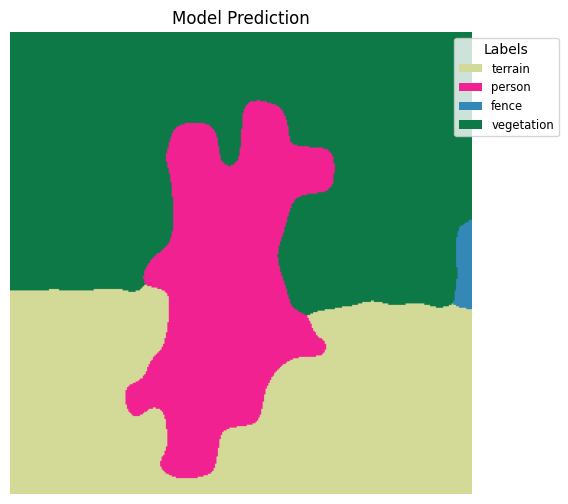

tensor([ 43, 125, 158, 191, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


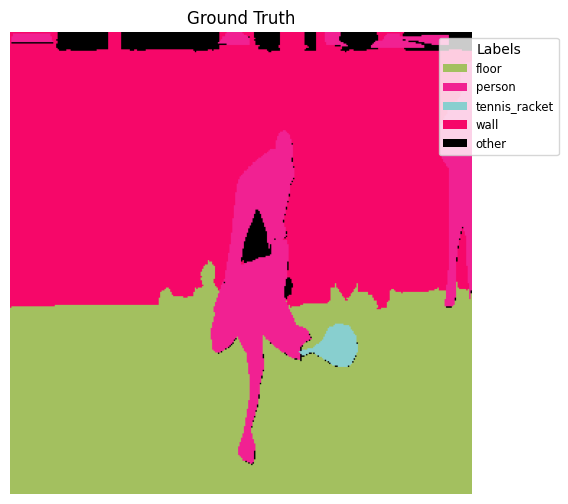

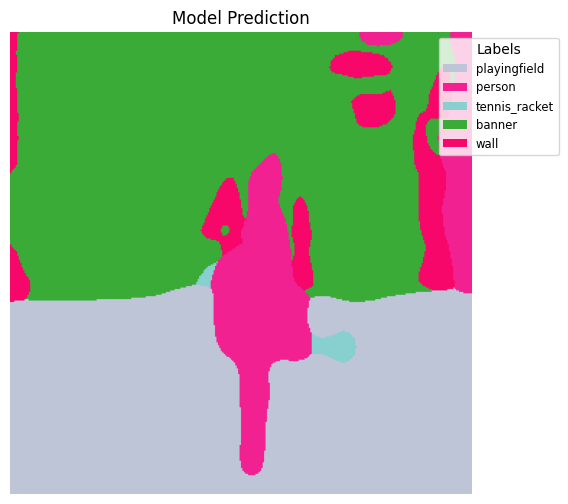

tensor([  0,   2,  96, 102, 125, 144, 158, 159, 174, 191, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


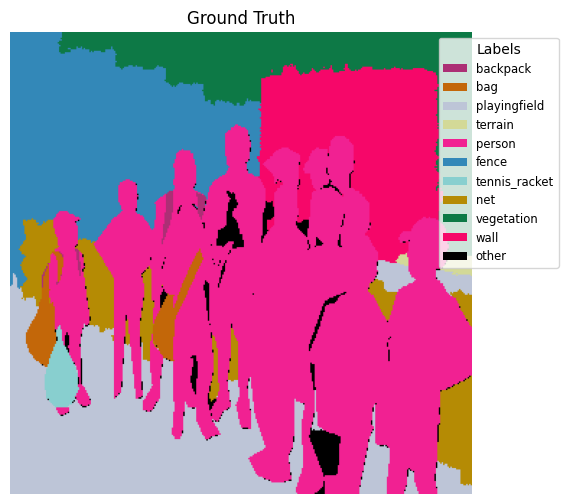

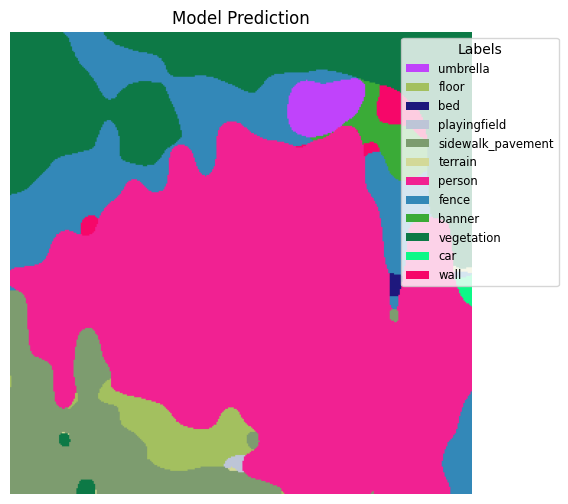

tensor([  0,   2,   6,  32,  35,  41,  94, 100, 125, 142, 148, 174, 184, 186,
        191, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


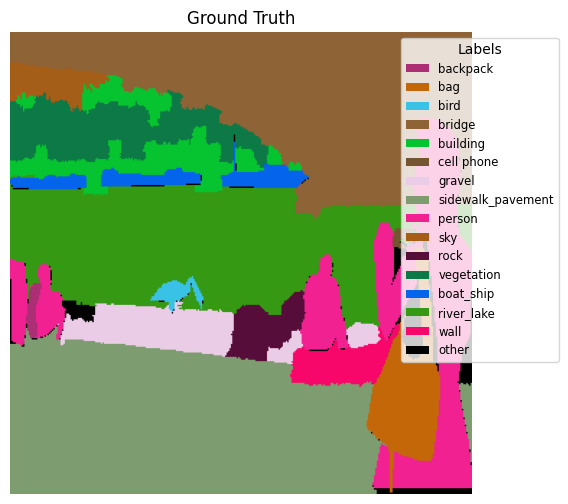

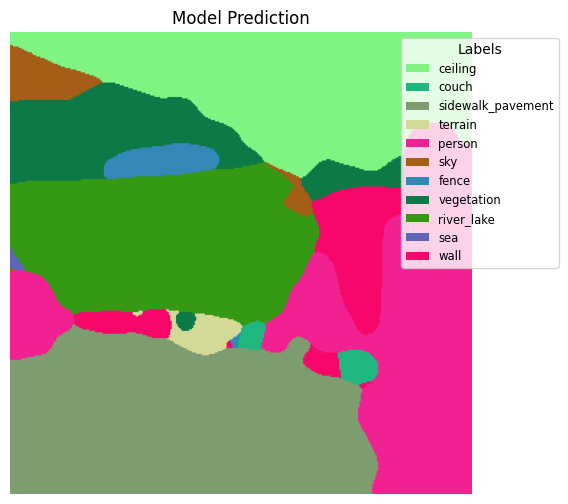

tensor([ 41, 105, 125, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


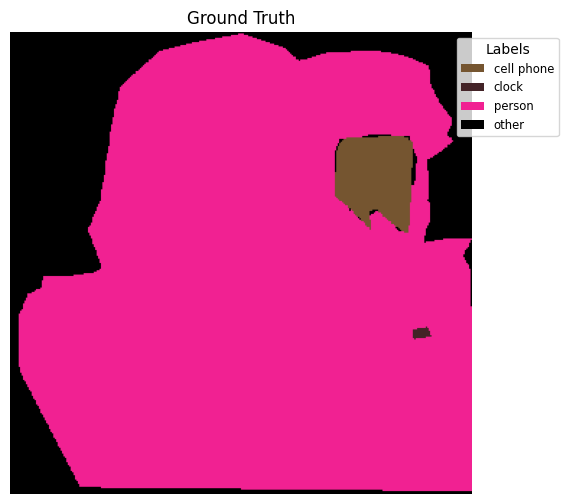

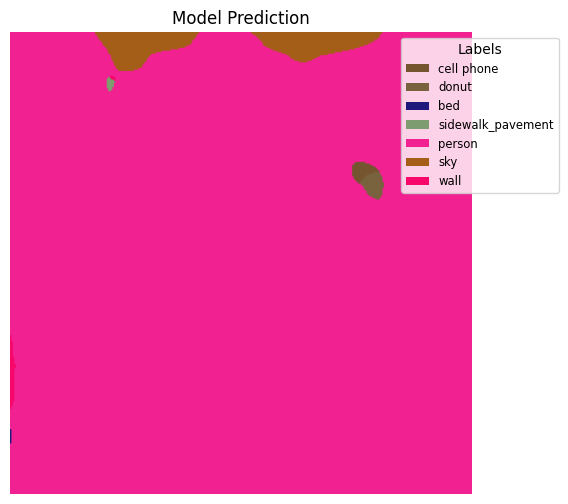

tensor([ 97, 125, 181, 191, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


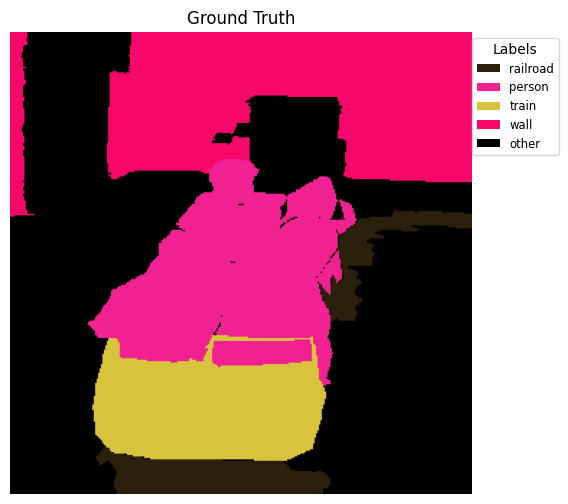

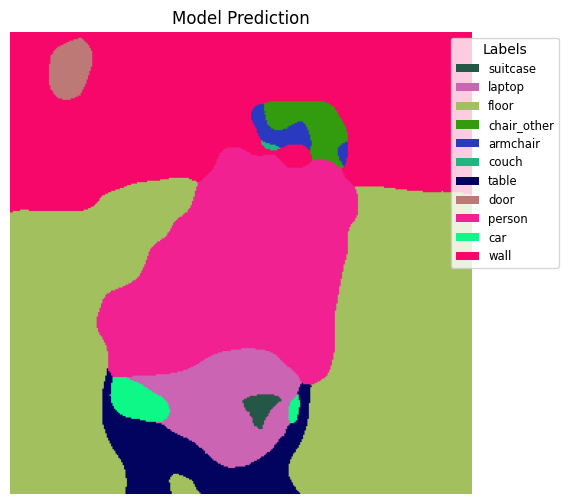

tensor([ 47,  56,  67, 121, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


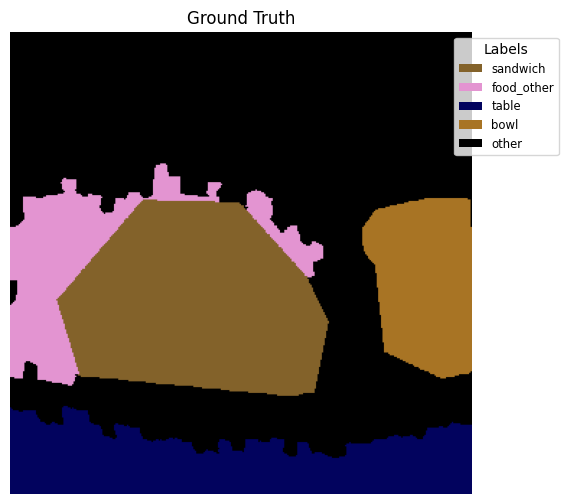

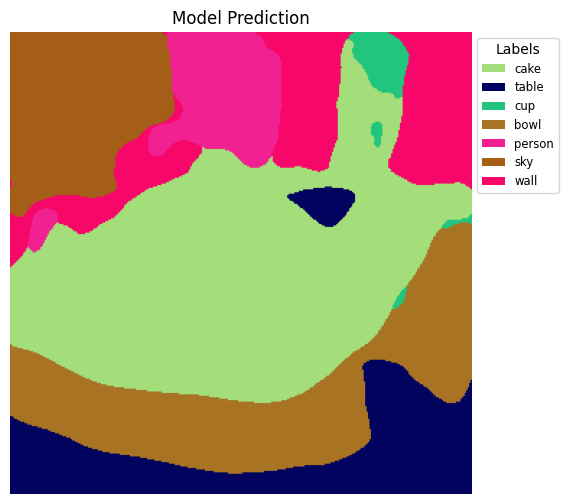

tensor([ 35, 125, 142, 157, 174, 187, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


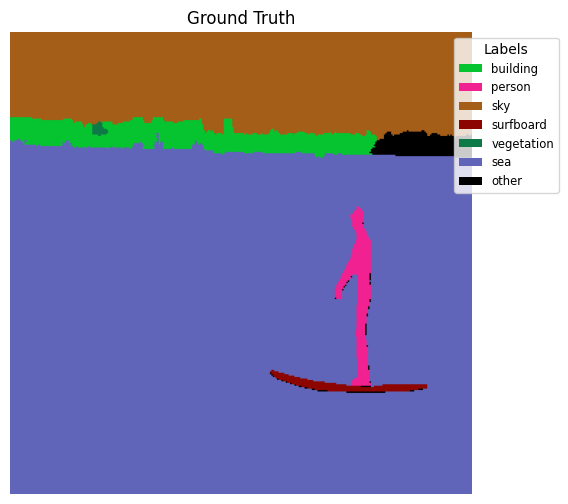

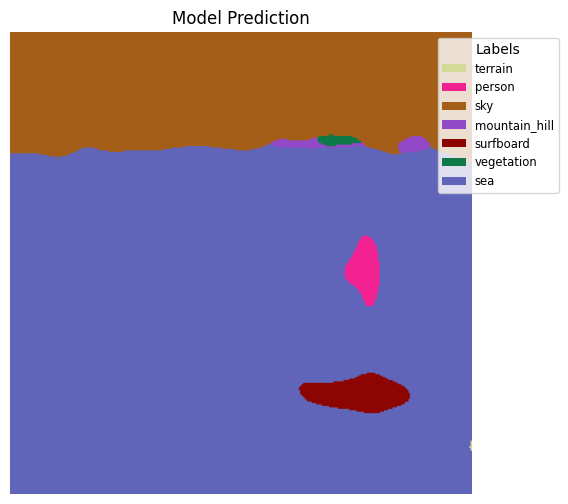

tensor([ 37,  38,  39,  42,  70,  82, 129, 191, 193, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


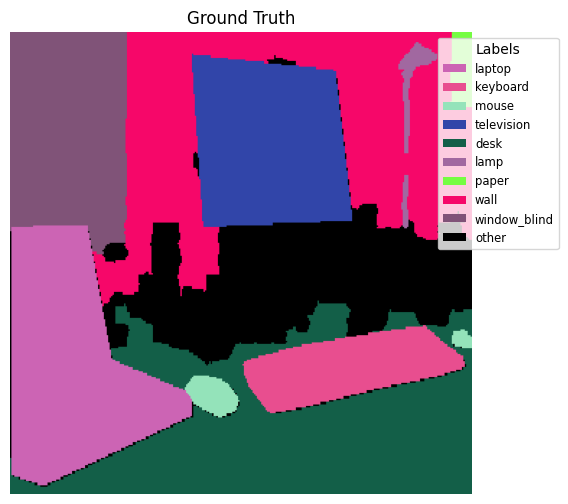

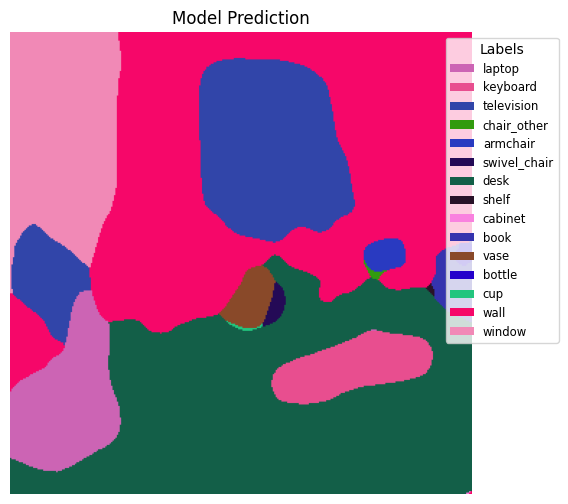

tensor([ 35,  98, 142, 174, 176, 182, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


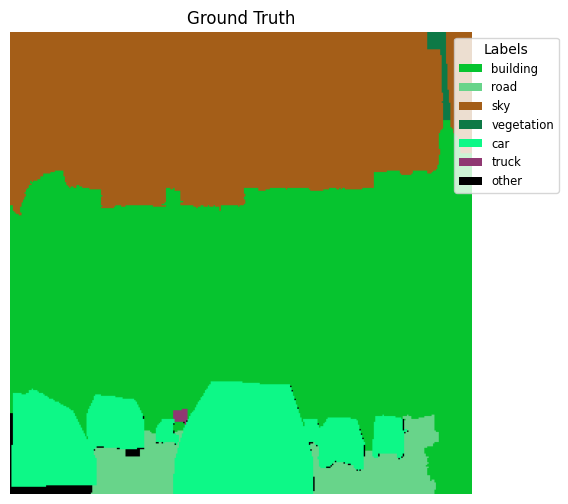

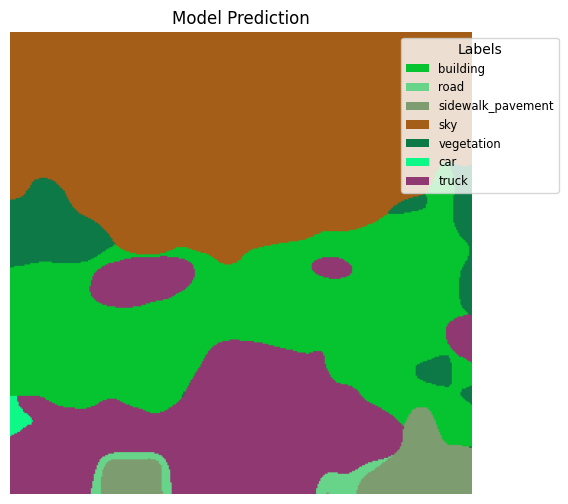

tensor([ 35,  98, 125, 142, 174, 180, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


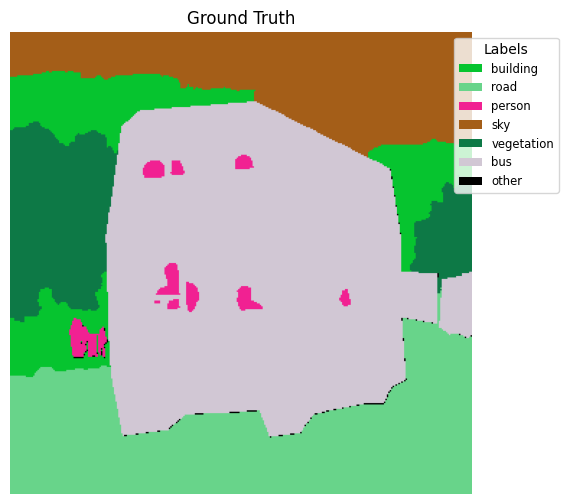

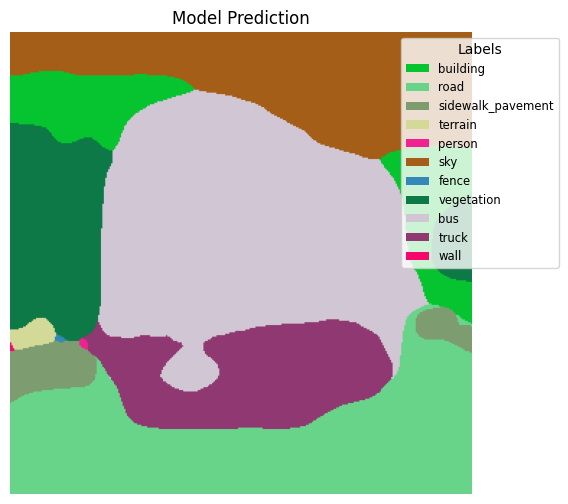

tensor([  7,  38, 129, 191, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


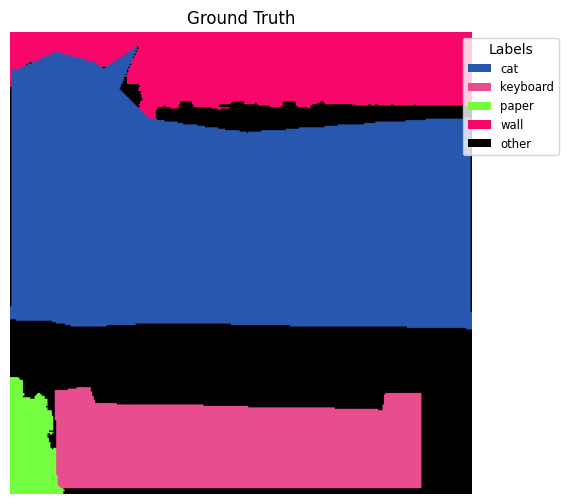

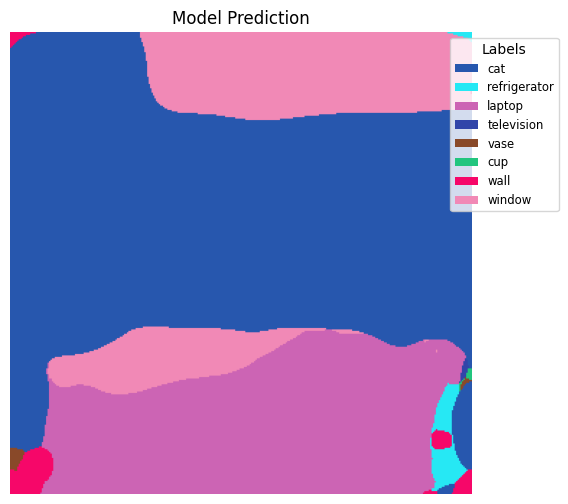

tensor([ 32,  35, 125, 142, 174, 179, 187, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


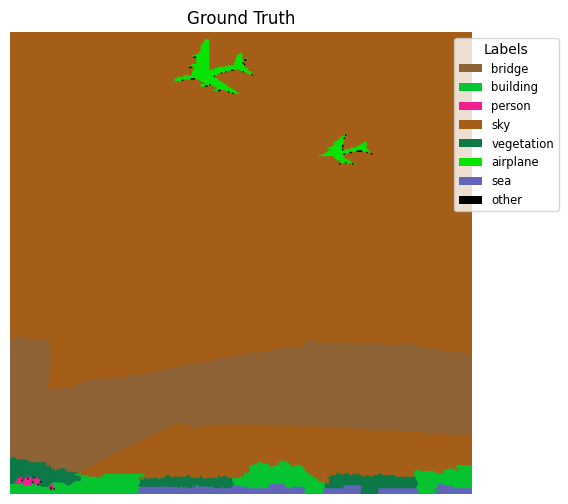

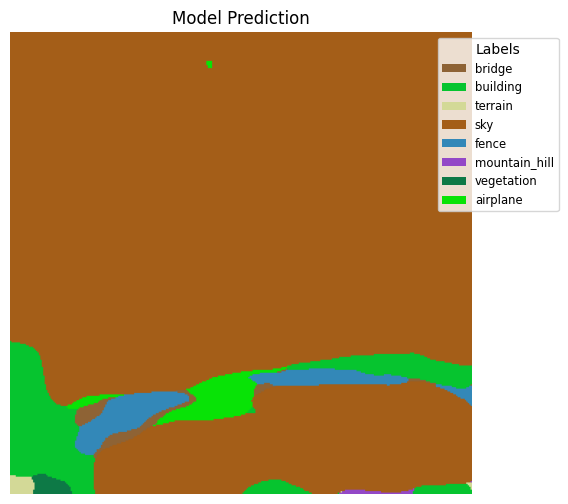

tensor([ 14, 102, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


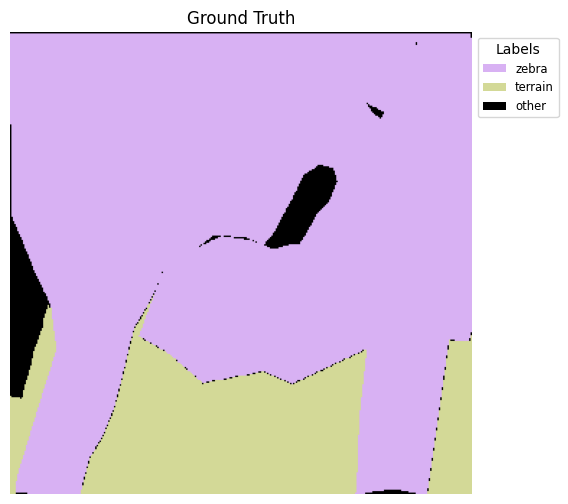

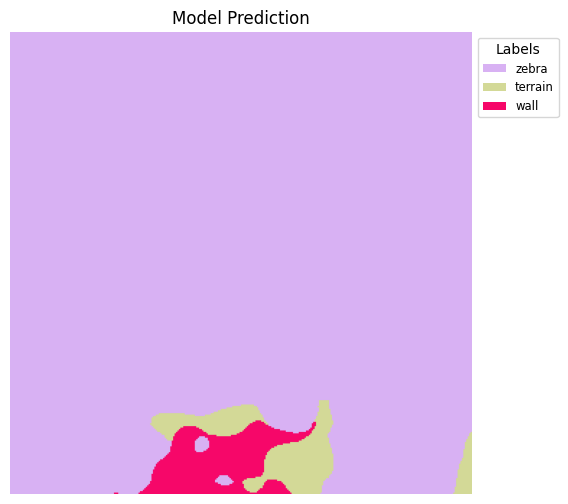

tensor([ 43,  58,  66,  67,  80, 191, 193, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


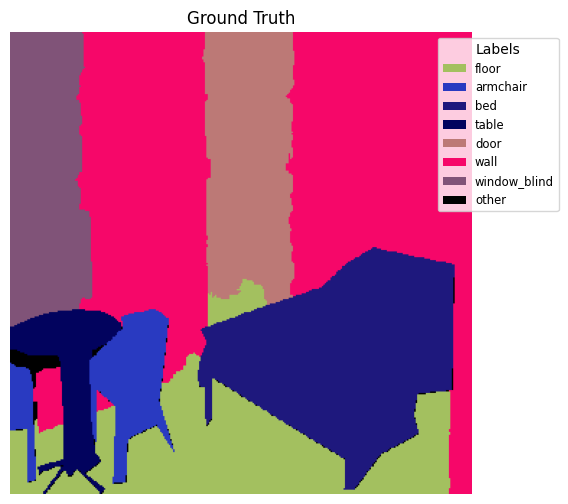

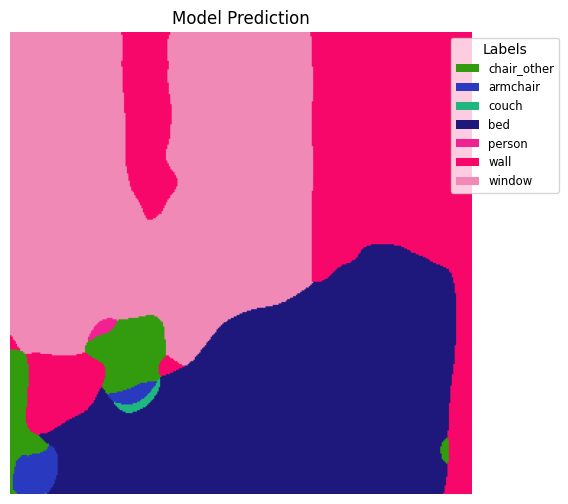

tensor([  3,  35,  98, 100, 125, 136, 142, 144, 174, 180, 191, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


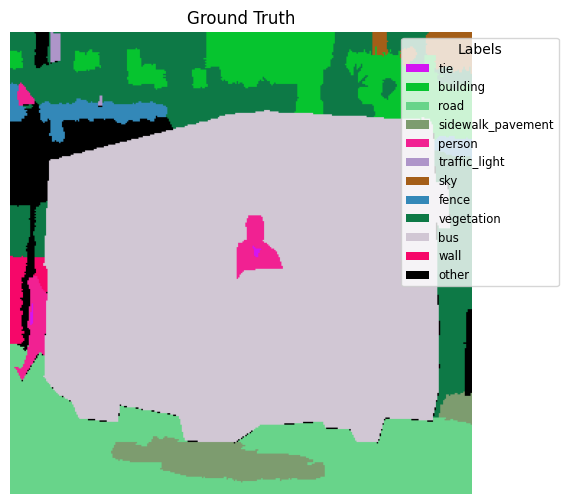

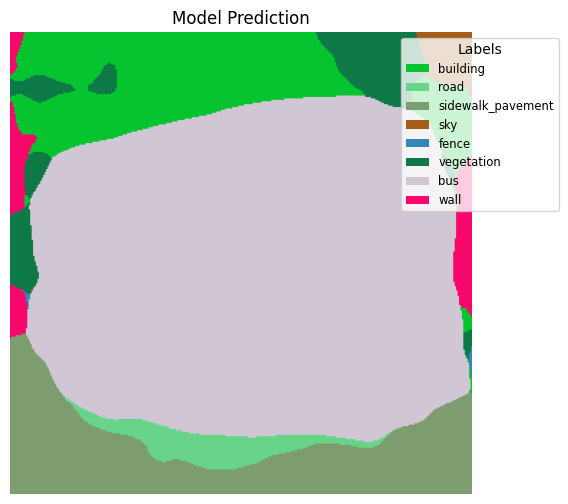

tensor([ 46, 121, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


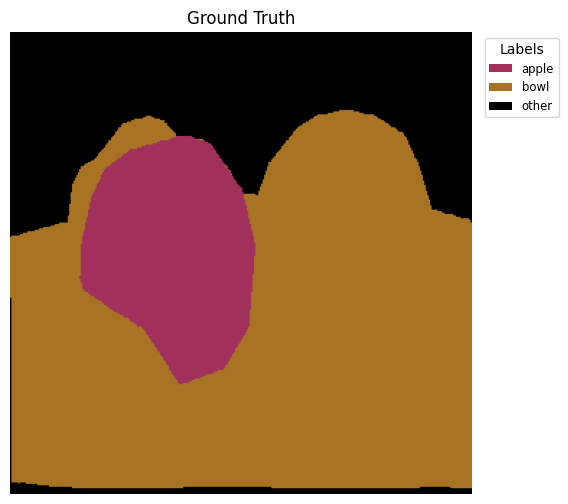

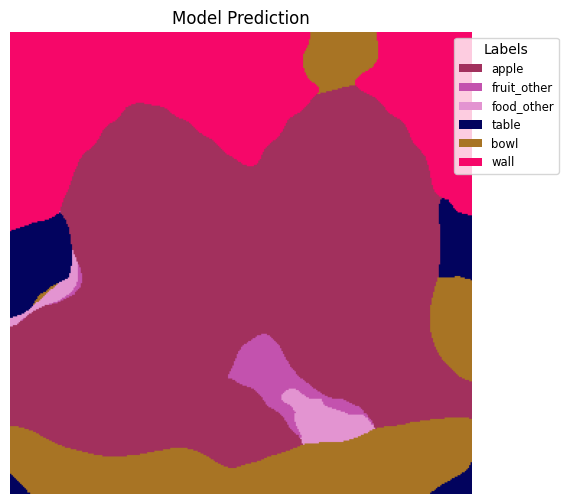

tensor([102, 125, 154, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


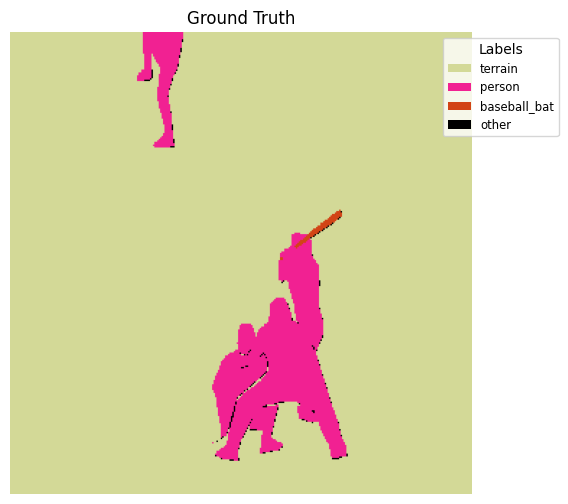

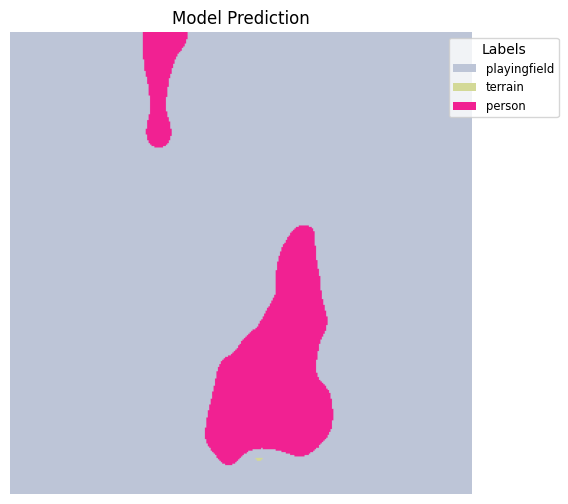

tensor([ 54,  67, 116, 117, 118, 174, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


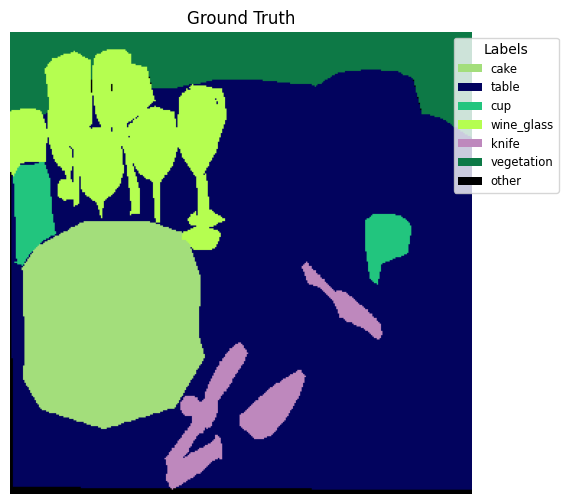

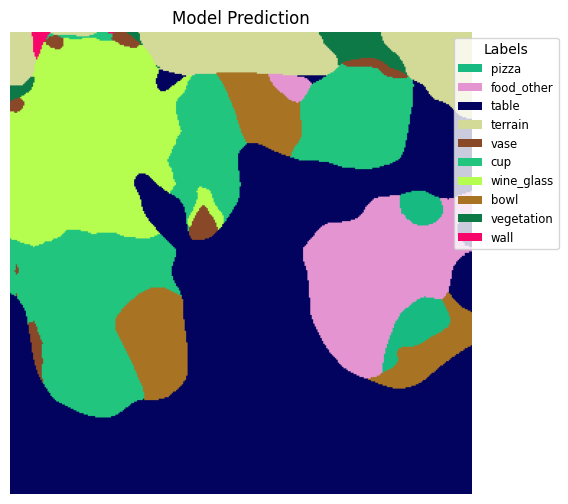

tensor([125, 157, 187, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


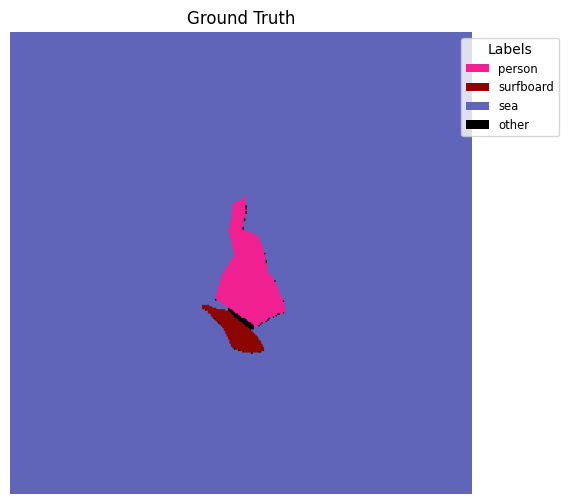

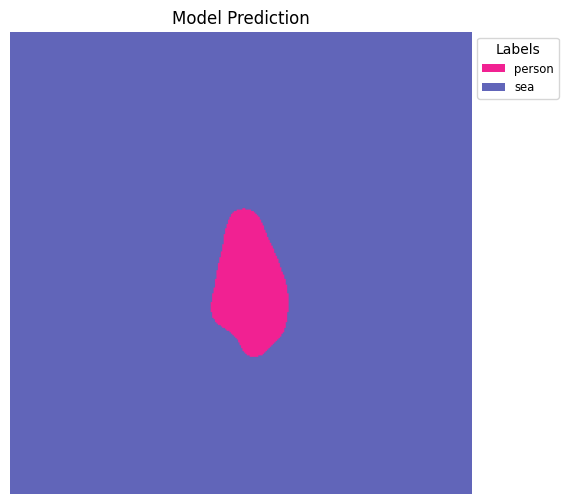

tensor([  3, 125, 191, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


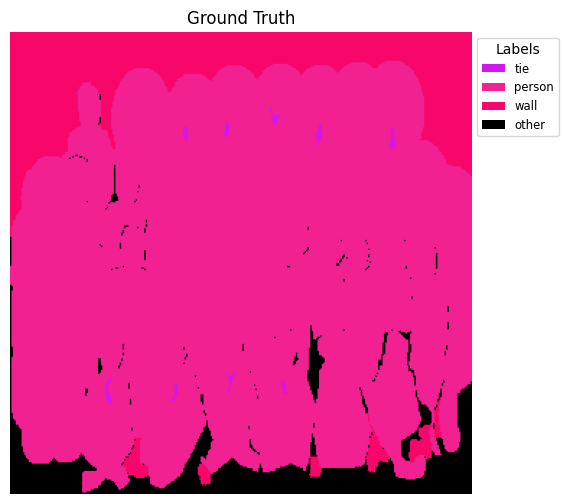

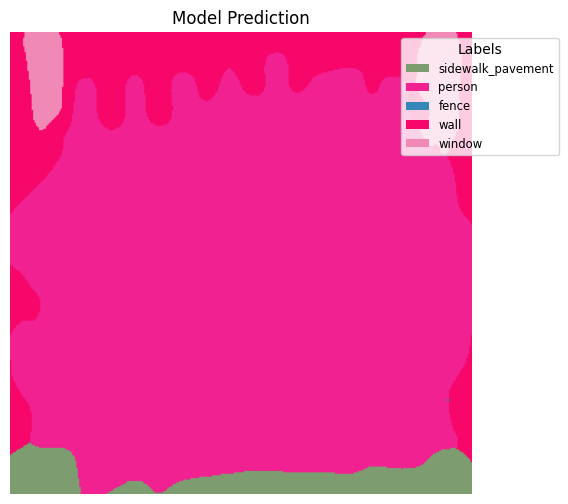

tensor([ 43,  67, 116, 117, 118, 120, 125, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


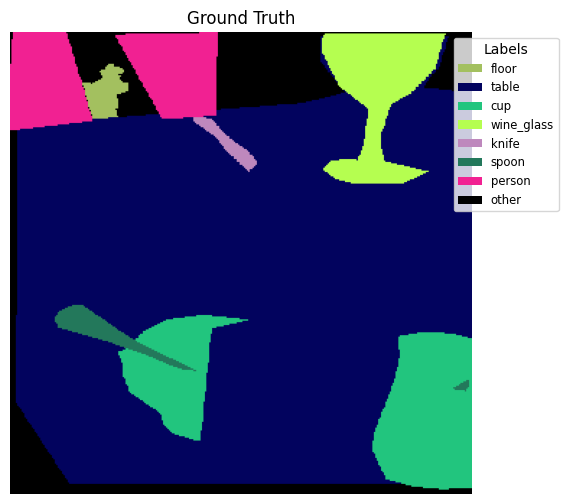

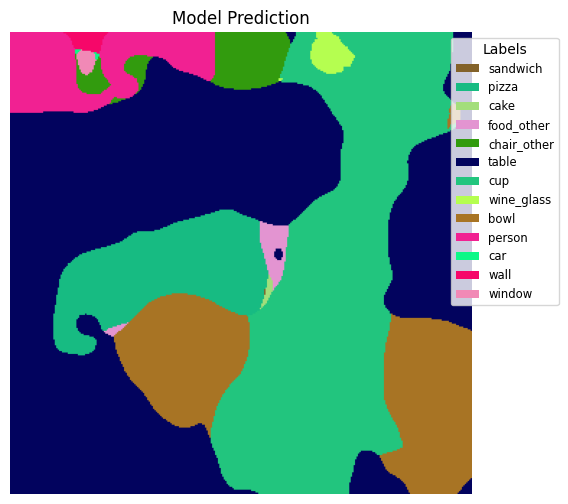

tensor([ 99, 125, 142, 150, 174, 194])


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


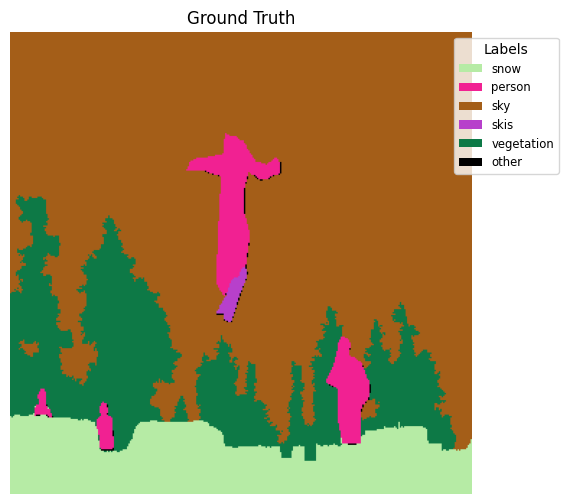

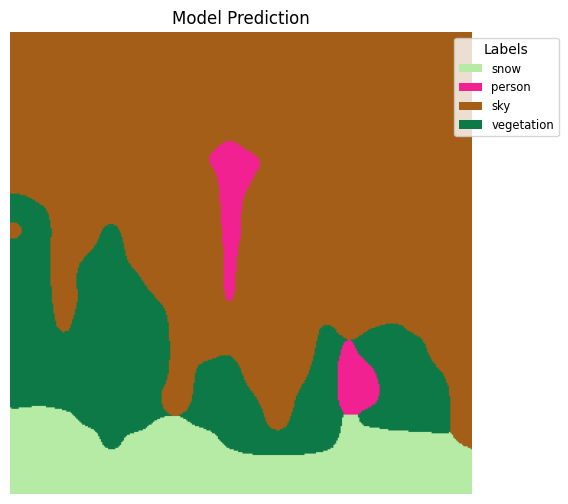

In [5]:
# Visualize Predictions
for i in range(30):  # Visualize first 3 samples
    img, label = test_dataset[i]
    img_batch = img.unsqueeze(0)  # Add batch dimension
    print(torch.unique(label))

    # Denormalize image for visualization
    img_batch_denorm = denormalize_image(img_batch.clone())
    visualize_images(img_batch_denorm)

    # Ground Truth
    visualize_predictions(label, color_map, labels, title="Ground Truth")

    # Model Prediction
    model = model.to(device="cuda").float()
    img_batch = img_batch.to(device="cuda").float()
    with torch.no_grad():
        output = model(img_batch)
        prediction = torch.argmax(output.squeeze(0), dim=0)
        visualize_predictions(prediction.cpu(), color_map, labels, title="Model Prediction")